In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random
import numpy as np
from tqdm import tqdm
import argparse
import wandb
from os.path import splitext
from os import listdir
import numpy as np
import os
from glob import glob
import torch
from torch.utils.data import Dataset
import logging
from PIL import Image
from torchvision.transforms import functional as TF
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import imageio.v2 as imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision import models
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import glob
import wandb
import random
import numpy as np
from model import *
from utils import *
from dataset import *

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
run = wandb.init()

In [3]:
dem_dir = '/home/macula/SMATousi/Gullies/ground_truth/google_api/training_process/DEM2SO/New_Data/dem'
so_dir = '/home/macula/SMATousi/Gullies/ground_truth/google_api/training_process/DEM2SO/New_Data/so'
rgb_dir = '/home/macula/SMATousi/Gullies/ground_truth/google_api/training_process/DEM2SO/New_Data/rgb'
pretrained_model_path = '/home/macula/SMATousi/cluster/docker-images/dem2so_more_data/pre_models/B3_rn50_moco_0099_ckpt.pth'



In [4]:
transform = RGB_RasterTransform()
    
dataset = RGB_RasterTilesDataset(dem_dir=dem_dir, so_dir=so_dir, rgb_dir=rgb_dir, transform=transform)

In [5]:
batch_size = 1
learning_rate = 0.0001
epochs = 1
number_of_workers = 0
image_size = 128
val_percent = 0.1

n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=number_of_workers, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=number_of_workers, pin_memory=True, drop_last=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    

In [6]:
print(device)

cuda


In [7]:
model = RGB_DEM_to_SO(resnet_output_size=(8, 8), 
                            fusion_output_size=(128, 128), 
                            model_choice = "Unet_1", 
                            resnet_saved_model_path=pretrained_model_path,
                            dropout_rate=0.5).to(device)

In [8]:
from torch.optim import Adam
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [ ]:
artifact_dir = artifact.download()

In [9]:
state_dict = torch.load('./artifacts/model_epoch_200:v6/model_epoch_200.pth')
new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

In [10]:
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [14]:
def mIOU(label, pred, num_classes=9):
    pred = F.softmax(pred, dim=1)              
    pred = torch.argmax(pred, dim=1).squeeze(1)
    iou_list = list()
    present_iou_list = list()

#     pred = pred.view(-1)
#     label = label.view(-1)
    # Note: Following for loop goes from 0 to (num_classes-1)
    # and ignore_index is num_classes, thus ignore_index is
    # not considered in computation of IoU.
    for sem_class in range(num_classes):
        pred_inds = (pred == sem_class)
        target_inds = (label == sem_class)
        if target_inds.long().sum().item() == 0:
            iou_now = float('nan')
        else: 
            intersection_now = (pred_inds[target_inds]).long().sum().item()
            union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
            iou_now = float(intersection_now) / float(union_now)
            present_iou_list.append(iou_now)
            # print(iou_now)
        iou_list.append(iou_now)
    return iou_list, present_iou_list, np.mean(present_iou_list)

import torch
import numpy as np

def mIOU_with_true_toleramce(label, pred, num_classes=9):
    pred = F.softmax(pred, dim=1)              
    pred = torch.argmax(pred, dim=1).squeeze(1)
    iou_list = list()
    present_iou_list = list()

#     pred = pred.view(-1)
#     label = label.view(-1)
    # Note: Following for loop goes from 0 to (num_classes-1)
    # and ignore_index is num_classes, thus ignore_index is
    # not considered in computation of IoU.
    for sem_class in range(num_classes):
        pred_inds = (pred == sem_class)
        if (sem_class == 1):
            pred_inds_tol = (pred == sem_class - 1) 
        elif (sem_class > 1):
            pred_inds_tol = (pred == sem_class - 1) 
            pred_inds_tol_2 = (pred == sem_class - 2) 
        target_inds = (label == sem_class)
        if target_inds.long().sum().item() == 0:
            iou_now = float('nan')
        else: 
            if (sem_class == 1):
                intersection_now = (pred_inds[target_inds]).long().sum().item()
                tol_intersection_now = (pred_inds_tol[target_inds]).long().sum().item()
                union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
                iou_now = (float(intersection_now) + float(tol_intersection_now)) / float(union_now)
                present_iou_list.append(iou_now)
            elif (sem_class > 1):
                intersection_now = (pred_inds[target_inds]).long().sum().item()
                tol_intersection_now = (pred_inds_tol[target_inds]).long().sum().item()
                tol2_intersection_now = (pred_inds_tol_2[target_inds]).long().sum().item()
                union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
                iou_now = (float(intersection_now) + float(tol_intersection_now) + float(tol2_intersection_now)) / float(union_now)
                present_iou_list.append(iou_now)
            else:
                intersection_now = (pred_inds[target_inds]).long().sum().item()
                union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
                iou_now = (float(intersection_now)) / float(union_now)
                present_iou_list.append(iou_now)
            # print(iou_now)
        iou_list.append(iou_now)
    return iou_list, present_iou_list, np.mean(present_iou_list)

def mIOU_with_tolerance(label, pred, num_classes=9):
    pred = torch.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)

    # Flatten label and prediction tensors
#     pred = pred.view(-1)
#     label = label.view(-1)

    iou_list = []
    present_iou_list = []

    for sem_class in range(num_classes):
        # Adjusting for tolerance: consider predictions that are one level above or below the target class
        pred_inds = ((pred == sem_class) | (pred == sem_class - 1) & (pred > 0) | (pred == sem_class + 1) & (pred < num_classes - 1))
        target_inds = ((label == sem_class) | (label == sem_class - 1) & (label > 0) | (label == sem_class + 1) & (label < num_classes - 1))

        if target_inds.long().sum().item() == 0:
            iou_now = float('nan')  # Class not present in the label
        else:
            intersection_now = (pred_inds & target_inds).long().sum().item()
            union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
            iou_now = float(intersection_now) / float(union_now)
            present_iou_list.append(iou_now)

        iou_list.append(iou_now)

    # Compute the mean of the present IoU scores, ignoring NaNs
    valid_iou_scores = [iou for iou in present_iou_list if not np.isnan(iou)]
    return iou_list, present_iou_list, valid_iou_scores, np.mean(valid_iou_scores) if valid_iou_scores else float('nan')

# Note: You'll need to replace 'F.softmax' and 'torch.argmax' with the appropriate calls to your prediction tensor,
# and ensure your label and pred tensors are in the correct shape and format.

def normalize_and_discretize_for_mIoU(label, pred, num_classes=9):
    # Ensure pred and label are torch tensors
    pred = torch.tensor(pred, dtype=torch.float32)
    label = torch.tensor(label, dtype=torch.float32)
    
    # Normalize by dividing by the maximum value in each tensor
    pred_argmax = torch.argmax(pred, dim=1)
    pred_max = pred_argmax.max() if pred_argmax.max() > 0 else 1  # Avoid division by zero
    label_max = label.max() if label.max() > 0 else 1
    pred_normalized = pred_argmax / pred_max
    label_normalized = label / label_max
    
#     print(pred_normalized.shape)
    
#     print(label_normalized.shape)

    # Discretize the normalized values
    pred_discrete = torch.round(pred_normalized * (num_classes - 1)).long()
    label_discrete = torch.round(label_normalized * (num_classes - 1)).long()

    # Flatten the tensors if they're not already, to prepare for mIoU calculation
    pred_flat = pred_discrete.view(-1)
    label_flat = label_discrete.view(-1)

    iou_list = []
    present_iou_list = []

    for sem_class in range(num_classes):
        pred_inds = (pred_flat == sem_class)
        target_inds = (label_flat == sem_class)

        if target_inds.long().sum().item() == 0:
            iou_now = float('nan')  # Class not present in the label
        else:
            intersection_now = (pred_inds & target_inds).long().sum().item()
            union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
            iou_now = float(intersection_now) / float(union_now)
            present_iou_list.append(iou_now)

        iou_list.append(iou_now)

    # Compute the mean of the present IoU scores, ignoring NaNs
    valid_iou_scores = [iou for iou in present_iou_list if not np.isnan(iou)]
    return present_iou_list, np.mean(valid_iou_scores) if valid_iou_scores else float('nan')



def compute_mIOU_for_region(label_region, pred_region, mIOU_fn, num_classes=9):
    _,_, mean_iou = mIOU_fn(label_region, pred_region, num_classes)
    return mean_iou

def regionalize_and_visualize_mIoU(label, pred, num_classes=9, grid_size=(8, 8), mIOU_fn=mIOU):
    # Assuming the 'label' and 'pred' are [C, H, W] where C is the number of classes
    height, width = label.shape[-2:]
    region_height = height // grid_size[0]
    region_width = width // grid_size[1]

    heatmap = np.zeros(grid_size)
    
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            label_region = label[:, i*region_height:(i+1)*region_height, j*region_width:(j+1)*region_width]
            pred_region = pred[:, :, i*region_height:(i+1)*region_height, j*region_width:(j+1)*region_width]
#             print(label_region.shape)
#             print(pred_region.shape)
            
            mean_iou = compute_mIOU_for_region(label_region, pred_region, mIOU_fn, num_classes)
            heatmap[i, j] = mean_iou
    
    # Normalize heatmap for visualization
    heatmap_normalized = heatmap
    
    return heatmap
    
    


In [15]:
model.eval()
val_iter = iter(val_loader)

0.030895233154296875


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/ipykernel_launcher.py:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(5, device='cuda:0')
Mean label: 0.9652099609375
Standard deviation: 0.8776793479919434


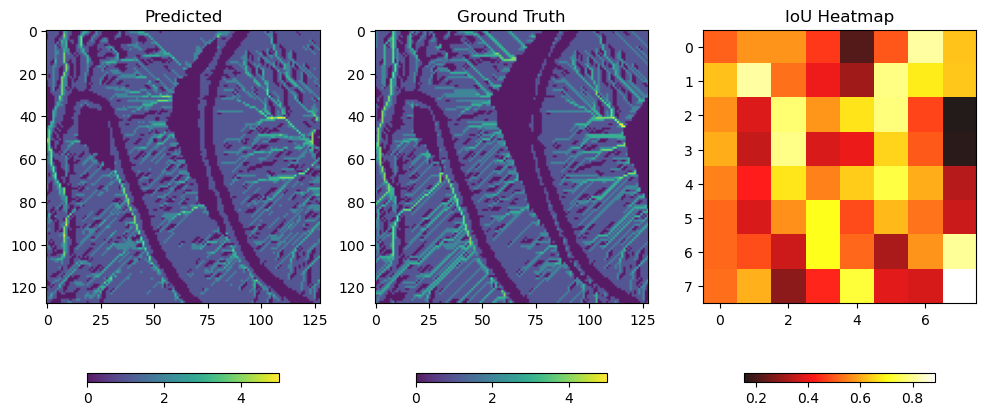

In [16]:
import time

batch = next(val_iter)
dem = batch['DEM'].to(device)
so = batch['SO'].to(device)
rgbs = [batch['RGB'][k].to(device) for k in range(6)]

start = time.time()
val_outputs = model(dem, rgbs)
end = time.time()

print(end - start)
loss = criterion(val_outputs, so)



iou_list, present_iou_list, iou = mIOU(so, val_outputs)
iou_list_tol, present_iou_list_tol, valid_iou_scores, iou_tol = mIOU_with_tolerance(so, val_outputs)
present_iou_list_norm, iou_norm = normalize_and_discretize_for_mIoU(so, val_outputs)
iou_list_tt, present_iou_list_tt, iou_tt = mIOU_with_true_toleramce(so, val_outputs)
heatmap = regionalize_and_visualize_mIoU(so, val_outputs, num_classes=9, grid_size=(8, 8), mIOU_fn=mIOU)

pred = F.softmax(val_outputs, dim=1)              
pred = torch.argmax(pred, dim=1).squeeze(1)

# Flatten the tensor to a single dimension for mean and std calculation
flat_labels = so.flatten()

# Calculate mean and standard deviation
mean_label = flat_labels.float().mean()
std_label = flat_labels.float().std()

print(flat_labels.max())
print(f"Mean label: {mean_label.item()}")
print(f"Standard deviation: {std_label.item()}")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# Plot for predicted
im1 = ax1.imshow(pred.cpu().numpy().squeeze(), alpha=0.9)
ax1.set_title("Predicted")
fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=0.7)

# Plot for ground truth
im2 = ax2.imshow(so.cpu().numpy().squeeze(), alpha=0.9)
ax2.set_title("Ground Truth")
fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=0.7)

im3 = ax3.imshow(heatmap, cmap='hot', alpha=0.9)
ax3.set_title("IoU Heatmap")
fig.colorbar(im3, ax=ax3, orientation='horizontal', shrink=0.7)

plt.show()

# plt.imshow(heatmap, cmap='hot', alpha=0.5)
# plt.colorbar()
# plt.title("Regional mIoU Heatmap")
# plt.show()

In [ ]:
print("Mean iou = ", iou_list_tt)

In [17]:
def compute_agreement(label, pred, threshold=0.5):
    
    pred = torch.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)

    match_per,diff = compare_gradients(label, pred, tolerance=0.00)

    binarized_predictions = (pred > threshold).float()
    binarized_so = (label > threshold).float()

    agreement = (binarized_predictions == binarized_so).float()
    agreement_percentage = agreement.mean().item() * 100
    
    return match_per, agreement_percentage
    

def compute_heatmap_for_batch(label, pred, num_classes=9, grid_size=(8, 8), mIOU_fn=mIOU):
    height, width = label.shape[-2:]
    region_height = height // grid_size[0]
    region_width = width // grid_size[1]

    heatmap = np.zeros(grid_size)
    gradient_match_percent = np.zeros(grid_size)
    total_agreement_percent = np.zeros(grid_size)
    
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            label_region = label[:, i*region_height:(i+1)*region_height, j*region_width:(j+1)*region_width]
            pred_region = pred[:, :, i*region_height:(i+1)*region_height, j*region_width:(j+1)*region_width]
            
            mean_iou = compute_mIOU_for_region(label_region, pred_region, mIOU_fn, num_classes)
            match_per, agreement_percentage = compute_agreement(label_region, pred_region)
            heatmap[i, j] = mean_iou
            gradient_match_percent[i, j] = match_per
            total_agreement_percent[i, j] = agreement_percentage
    
    return heatmap, gradient_match_percent, total_agreement_percent

def accumulate_and_average_heatmaps(val_iter, model, num_classes=9, grid_size=(8, 8), mIOU_fn=mIOU):
    accumulated_heatmaps = []
    accumulated_agreement = []
    accumulated_gradient_match = []
    
    for batch in tqdm(val_iter):
        dem = batch['DEM'].to(device)
        so = batch['SO'].to(device)
        rgbs = [batch['RGB'][k].to(device) for k in range(6)]
        
        val_outputs = model(dem, rgbs)
        heatmap, gradient_match_percent, agreement_percent = compute_heatmap_for_batch(so, val_outputs, num_classes, grid_size, mIOU_fn)
#         print(heatmap.shape, gradient_match_percent.shape, agreement_percent.shape)
        accumulated_heatmaps.append(heatmap)
        accumulated_agreement.append(agreement_percent)
        accumulated_gradient_match.append(gradient_match_percent)
        
    
    # Compute the average heatmap
    average_heatmap = np.mean(accumulated_heatmaps, axis=0)
    average_agreement = np.mean(accumulated_agreement, axis=0)
    average_gradient_match = np.mean(accumulated_gradient_match, axis=0)
#     print(average_heatmap.shape, average_agreement.shape, average_gradient_match.shape)
    return average_heatmap, average_agreement, average_gradient_match

def visualize_average_heatmap(average_heatmap, title):
#     heatmap_normalized = average_heatmap / np.nanmax(average_heatmap)
#     plt.imshow(heatmap_normalized, cmap='hot', alpha=0.5)
#     plt.colorbar()
#     plt.title("Normalized Average Regional mIoU Heatmap")
#     plt.show()
    plt.imshow(average_heatmap, cmap='hot', alpha=0.5)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [ ]:
val_iter = iter(val_loader)
average_heatmap, average_agreement, average_gradient_match = accumulate_and_average_heatmaps(val_iter, model, num_classes=9, grid_size=(8, 8), mIOU_fn=mIOU)
# visualize_average_heatmap(average_heatmap_16)


In [30]:
calculate_mean_std(val_outputs)

(tensor(1.3556, device='cuda:0'), tensor(0.7414, device='cuda:0'))

In [18]:
def calculate_average_mIOU(val_iter, model, num_classes=9, threshold=0.5):
    total_present_iou_list = []
    total_iou = []
    list_of_ious = []
    list_of_ious_tol = []
    
    list_of_ious_tt = []
    
    total_present_iou_list_tol = []
    total_iou_tol = []
    
    total_agreement_percentage = []
    total_disagreement_percentage = []
    total_false_negative_percentage = []
    total_false_positive_percentage = []
    
    derivative_match_perc = []
    
    pred_mean_total = []
    pred_std_total = []
    
    so_mean_total = []
    so_std_total = []

    for batch in tqdm(val_iter):
        dem = batch['DEM'].to(device)
        so = batch['SO'].to(device)
        rgbs = [batch['RGB'][k].to(device) for k in range(6)]
        
        # Assuming your model's prediction step
        val_outputs = model(dem, rgbs)
        
        
        pred = torch.softmax(val_outputs, dim=1)
        pred = torch.argmax(pred, dim=1)
        
        binarized_predictions = (pred > threshold)
        binarized_so = (so > threshold)
        
        agreement = (binarized_predictions & binarized_so).float()
        agreement_percentage = agreement.mean().item() * 100
        total_agreement_percentage.append(agreement_percentage)
        
        agreement_binary = (binarized_predictions == binarized_so)
        
        pred_masked = pred * agreement
        so_masked = so * agreement
        
        pred_mean, pred_std = calculate_mean_std(pred_masked)
        so_mean, so_std = calculate_mean_std(so_masked)
        
        pred_mean_total.append(pred_mean.item())
        pred_std_total.append(pred_std.item())
        so_mean_total.append(so_mean.item())
        so_std_total.append(so_std.item())
        
        
        match_per,diff = compare_gradients(so_masked, pred_masked, tolerance=0.00)
        
        derivative_match_perc.append(match_per)
        
        
        
        
        
        false_positive = (binarized_predictions & (~binarized_so)).float()
        false_positive_percentage = false_positive.mean().item() * 100
        total_false_positive_percentage.append(false_positive_percentage)
        
        false_negative = ((~binarized_predictions) & binarized_so).float()
        false_negative_percentage = false_negative.mean().item() * 100
        total_false_negative_percentage.append(false_negative_percentage)
        
        disagreement = (~binarized_predictions & ~binarized_so).float()
        disagreement_percentage = disagreement.mean().item() * 100  # Convert to percentage
        total_disagreement_percentage.append(disagreement_percentage)

        
        iou_list_tt, present_iou_list_tt, iou_tt = mIOU_with_true_toleramce(so, val_outputs)
        list_of_ious_tt.append(iou_list_tt)
        # Calculate mIOU for the current batch
        iou_list, present_iou_list, iou = mIOU(so, val_outputs, num_classes)
        if not np.isnan(iou):
            total_iou.append(iou)
            
        iou_list_tol, present_iou_list_tol, valid_iou_scores, iou_tol = mIOU_with_tolerance(so, val_outputs, num_classes)
        if not np.isnan(iou_tol):
            total_iou_tol.append(iou_tol)
            
        total_present_iou_list_tol.extend([iou for iou in valid_iou_scores if not np.isnan(iou)])
        list_of_ious.append(iou_list)
        list_of_ious_tol.append(iou_list_tol)
        # Extending the list of present IoUs for all batches
        total_present_iou_list.extend([iou for iou in present_iou_list if not np.isnan(iou)])
        
#         break
    
    # Compute the mean of present IoUs and overall IoU across all batches
    mean_present_iou = np.mean(total_present_iou_list) if total_present_iou_list else float('nan')
    mean_iou = np.mean(total_iou) if total_iou else float('nan')
    
    mean_present_iou_tol = np.mean(total_present_iou_list_tol) if total_present_iou_list_tol else float('nan')
    mean_iou_tol = np.mean(total_iou_tol) if total_iou_tol else float('nan')
    
    mean_agreement_percentage = np.mean(total_agreement_percentage) if total_agreement_percentage else float('nan')    
    mean_disagreement_percentage = np.mean(total_disagreement_percentage) if total_disagreement_percentage else float('nan')    
    
    mean_false_positive = np.mean(total_false_positive_percentage) if total_false_positive_percentage else float('nan')    
    mean_false_negative = np.mean(total_false_negative_percentage) if total_false_negative_percentage else float('nan')    

    mean_derivative_match = np.mean(derivative_match_perc)
    
    pred_mean = np.nanmean(pred_mean_total)
    pred_std = np.nanmean(pred_std_total)
    so_mean = np.nanmean(so_mean_total)
    so_std = np.nanmean(so_std_total)
    
    mean_std_results = [pred_mean, pred_std, so_mean, so_std]
    
    return mean_present_iou, \
            mean_iou, \
            mean_present_iou_tol, \
            mean_iou_tol, \
            list_of_ious_tol, \
            list_of_ious, \
            list_of_ious_tt, \
            mean_agreement_percentage, \
            total_agreement_percentage, \
            mean_disagreement_percentage, \
            disagreement_percentage, \
            mean_derivative_match, \
            derivative_match_perc, \
            mean_false_positive, \
            mean_false_negative, \
            mean_std_results



def kl_divergence(mu1, sigma1, mu2, sigma2):
    """
    Compute the KL divergence between two Gaussian distributions.

    Parameters:
    - mu1, sigma1: Mean and standard deviation of the first Gaussian distribution.
    - mu2, sigma2: Mean and standard deviation of the second Gaussian distribution.

    Returns:
    - The KL divergence between the two distributions.
    """
    return np.log(sigma2/sigma1) + ((sigma1**2 + (mu1 - mu2)**2) / (2 * sigma2**2)) - 0.5


def calculate_mean_std(image):
    
    
#     pred = F.softmax(image, dim=1)              
#     pred = torch.argmax(pred, dim=1).squeeze(1)

    # Flatten the tensor to a single dimension for mean and std calculation
    flat_labels = image.flatten()
    non_zero_mask = flat_labels != 0
    non_zero_labels = flat_labels[non_zero_mask]

    # Calculate mean and standard deviation
    mean_label = non_zero_labels.float().mean()
    std_label = non_zero_labels.float().std()
    
    return mean_label, std_label
    
    
def calculate_gradient_magnitude(image):
    """Calculate the gradient magnitude of an image using the Sobel operator."""
    sobel_x = torch.tensor([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(image.device)
    sobel_y = torch.tensor([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(image.device)
    
    grad_x = F.conv2d(image.type(torch.float32), sobel_x, padding=1)
    grad_y = F.conv2d(image.type(torch.float32), sobel_y, padding=1)
    
    gradient_magnitude = torch.sqrt(grad_x**2 + grad_y**2)
    return gradient_magnitude

def compare_gradients(so, predictions, tolerance=0.05):
    """Compare the gradient magnitudes of SO and predictions, returning the percentage of matches."""
#     print(so.shape)
#     print(predictions.shape)
    so_grad_mag = calculate_gradient_magnitude(so)
    predictions_grad_mag = calculate_gradient_magnitude(predictions)
    
    # Compute the absolute difference between the two gradient magnitudes
    diff = torch.abs(so_grad_mag - predictions_grad_mag)
    
    # Determine matches based on the tolerance threshold
    matches = diff <= tolerance
    
    # Calculate the percentage of matches
    match_percentage = matches.float().mean().item() * 100
    
    return match_percentage, diff

def compare_gradients_modified(so, predictions, tolerance=0.05):
    """Compare the gradient magnitudes of SO and predictions, returning the percentage of matches."""
#     print(so.shape)
#     print(predictions.shape)
    so_grad_mag = calculate_gradient_magnitude(so)
    predictions_grad_mag = calculate_gradient_magnitude(predictions)
    
    # Compute the absolute difference between the two gradient magnitudes
    diff = torch.abs(so_grad_mag - predictions_grad_mag)
    
    # Determine matches based on the tolerance threshold
    matches = diff <= tolerance
    
    # Calculate the percentage of matches
    match_percentage = matches.float().mean().item() * 100
    
    return match_percentage, diff, so_grad_mag, predictions_grad_mag
            


In [50]:
val_iter = iter(val_loader)
mean_present_iou, \
mean_iou, \
mean_present_iou_tol, \
mean_iou_tol, \
list_of_ious_tol, \
list_of_ious, \
list_of_ious_tt, \
mean_agreement_percentage, \
total_agreement_percentage, \
mean_disagreement_percentage, \
disagreement_percentage, \
mean_derivative_match, \
derivative_match_perc, \
mean_false_positive, \
mean_false_negative,\
mean_std_results = calculate_average_mIOU(val_iter, model, num_classes=9, threshold=6.5)





100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3373/3373 [03:25<00:00, 16.40it/s]


In [20]:
mean_std_results

[2.470413411527235, 0.7048853435100116, 2.648823521341111, 0.8476857708063588]

inf


/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/ipykernel_launcher.py:150: RuntimeWarning: divide by zero encountered in double_scalars
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


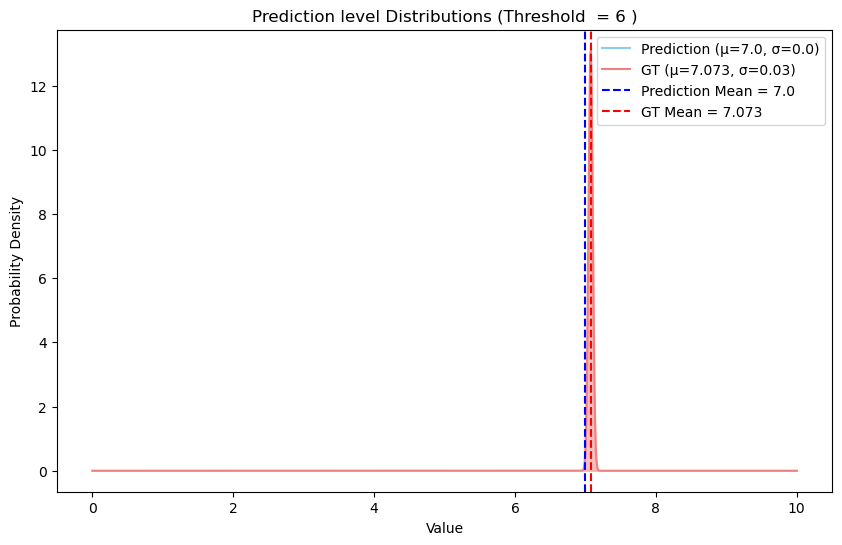

In [51]:
mean1, std1 = mean_std_results[0], mean_std_results[1]
mean2, std2 = mean_std_results[2], mean_std_results[3]

print(kl_divergence(mean1, std1, mean2, std2))

# x1 = np.linspace(mean1 - 3*std1, mean1 + 3*std1, 1000)
# y1 = (1 / (std1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x1 - mean1) / std1) ** 2)

# x2 = np.linspace(mean2 - 3*std2, mean2 + 3*std2, 1000)
# y2 = (1 / (std2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x2 - mean2) / std2) ** 2)

x1 = np.linspace(0, 10, 1000)
y1 = (1 / (std1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x1 - mean1) / std1) ** 2)

x2 = np.linspace(0, 10, 1000)
y2 = (1 / (std2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x2 - mean2) / std2) ** 2)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(x1, y1, color='skyblue', label=f'Prediction (μ={round(mean1,3)}, σ={round(std1,3)})')
plt.fill_between(x1, y1, color='skyblue', alpha=0.5)

plt.plot(x2, y2, color='lightcoral', label=f'GT (μ={round(mean2,3)}, σ={round(std2,3)})')
plt.fill_between(x2, y2, color='lightcoral', alpha=0.5)

# Mean lines
plt.axvline(mean1, color='blue', linestyle='dashed', label=f'Prediction Mean = {round(mean1,3)}')
plt.axvline(mean2, color='red', linestyle='dashed', label=f'GT Mean = {round(mean2,3)}')

# Legend and labels
plt.legend()
plt.title('Prediction level Distributions (Threshold  = 6 )')
plt.xlabel('Value')
plt.ylabel('Probability Density')

plt.show()

In [ ]:
# print(mean_present_iou)
print("Mean IoU = ", mean_iou)
# print(mean_present_iou_tol)
print("Mean IoU with 1 level tolerance = ", mean_iou_tol)

print("Total Agreement = ", mean_agreement_percentage)

print("Total false pos = ", mean_false_positive)
print("Total false neg = ", mean_false_negative)

print("Total Disagreement = ", mean_disagreement_percentage)

print("Total derivative match = ", mean_derivative_match)
# print(np.mean(average_heatmap))
# visualize_average_heatmap(average_heatmap)

In [ ]:
model.eval()
val_iter = iter(val_loader)

In [ ]:


import time

batch = next(val_iter)
dem = batch['DEM'].to(device)
so = batch['SO'].to(device)
rgbs = [batch['RGB'][k].to(device) for k in range(6)]

start = time.time()
val_outputs = model(dem, rgbs)
end = time.time()

pred = torch.softmax(val_outputs, dim=1)
pred = torch.argmax(pred, dim=1)

# match_per,diff = compare_gradients(so, pred, tolerance=0.00)
match_percentage, diff, so_grad_mag, predictions_grad_mag = compare_gradients_modified(so, pred, tolerance=0.00)
    
print("Time of the calculation: ", end - start)

loss = criterion(val_outputs, so)

iou_list, present_iou_list, iou = mIOU(so, val_outputs)
iou_list_tol, present_iou_list_tol, valid_iou_scores, iou_tol = mIOU_with_tolerance(so, val_outputs)
present_iou_list_norm, iou_norm = normalize_and_discretize_for_mIoU(so, val_outputs)
iou_list_tt, present_iou_list_tt, iou_tt = mIOU_with_true_toleramce(so, val_outputs)
heatmap = regionalize_and_visualize_mIoU(so, val_outputs, num_classes=9, grid_size=(8, 8), mIOU_fn=mIOU)

pred = F.softmax(val_outputs, dim=1)              
pred = torch.argmax(pred, dim=1).squeeze(1)

threshold = 1

binarized_predictions = (pred > threshold)
binarized_so = (so > threshold)

masked_pred = binarized_predictions * pred
masked_so = binarized_so * so

print("Total Gradient agreement: ", match_percentage)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# Plot for predicted
im1 = ax1.imshow(masked_pred.cpu().numpy().squeeze(), alpha=0.9)
ax1.set_title("Predicted")
fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=0.7)

# Plot for ground truth
im2 = ax2.imshow(masked_so.cpu().numpy().squeeze(), alpha=0.9)
ax2.set_title("Ground Truth")
fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=0.7)

im3 = ax3.imshow(heatmap, alpha=0.9)
ax3.set_title("IoU Heatmap")
fig.colorbar(im3, ax=ax3, orientation='horizontal', shrink=0.7)

plt.show()

# plt.imshow(heatmap, cmap='hot', alpha=0.5)
# plt.colorbar()
# plt.title("Regional mIoU Heatmap")
# plt.show()

match_percentage, diff, so_grad_mag, predictions_grad_mag = compare_gradients_modified(so, pred, tolerance=0.00)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# Plot for predicted
im1 = ax1.imshow(predictions_grad_mag.cpu().numpy().squeeze(), alpha=0.9)
ax1.set_title("Predicted Gradient")
fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=0.7)

# Plot for ground truth
im2 = ax2.imshow(so_grad_mag.cpu().numpy().squeeze(), alpha=0.9)
ax2.set_title("Ground Truth Gradient")
fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=0.7)

im3 = ax3.imshow(diff.cpu().numpy().squeeze(), cmap='hot', alpha=0.9)
ax3.set_title("Difference")
fig.colorbar(im3, ax=ax3, orientation='horizontal', shrink=0.7)

plt.show()

In [ ]:
match_per

In [ ]:
diff.min()

In [ ]:
match_per

In [ ]:
list_of_ious_tt[2]

In [ ]:
list_iou_tol_array = np.array(list_of_ious_tt)
list_iou_array = np.array(list_of_ious)

In [ ]:
print(np.nanmean(list_iou_tol_array, axis=0))
print(np.nanmean(list_iou_array, axis=0))